# SASCA Tutorial

In the following, we will describe how to run a SASCA by using Stella. As an overview, this tutorial is composed in a few steps
* Generate a file that describes the implementation to attack.
* Generate traces 
* Compute SNR on all the variables to profile within the graph and build the model
* Generate the appropriate factor graph to run the attack
* Perform belief propagation on the graph to generate the attack

In this tutorial, we will mount a factor graph on a unprotected AES in a D&C fashion. We will do known and unknown plaintext attacks. For the tutorial to be short, all the function specific to this cases are stored in this directory but not in the notebook. (default path for simulated traces storage are also given there). 

## Step 1: Writing a graph file
In order to describe the factor graph, we rely on a .txt file which is parsed by Stella. The file is formatted in the following way for our D&C AES attack:

```
k0 #secret

#indeploop

p0 #public
x0 #nonprofile
y0 #profile

x0 = k0 ^ p0
y0 = 0 loopup x0

#endindeploop

```
In this example, the variables (k0,p0,x0) can take 3 flags:
* `secret`: means that this is a variable that the adversary wants to known the distribution of. After the attack, he will get such a distribution. These are typically the keys.
* `public`: this is a public variable which is so known to the adversary. During the attack, that variable value has to be given to Stella. These are typically the plaintexts.
* `profile`: is a variable that will be profiled by Stella (it will estimate a pdf for it). During the attack, a probability table has to be given to Stella.This is typically the output of the Sbox.
* `nonprofile`: is a variable that has a distribution but does not requires to be profiled (i.e. the input of the Sbox)

The `indeploop` tag must contain the encryption loop. The number of iteration can be chosen later on from the Python interface.

In order to generate such a file, [gen_file.py](gen_file.py) contains such a function. We import it and generate the file.
* Known Plaintext: For a known plaintext attack, the plaintext is public and so has the flag 'public'
* Unknown Plaintext: For a unknown plaintext attack, the adversary estimates a distribution for the plaintext. It so has the flag 'profile'.

In [17]:
from gen_file import write_file
file_name = "my_example.txt"

write_file(file_name=file_name,
          keyflag="secret",
          ptflag="public",
          indepk=False,
          transition = False, #add transition between consecutive bytes
          nbytes=4)         # max 16 for this example to match the traces simulation script

In order to visualize the factor graph, you can ask Stella to parse the file and generate the graph.
You can then change the flags in the file, the number of iteration and enjoy the visualization. It only shows the variable with a distribution (so not the public inputs).

In [18]:
from stella.attacks.sasca.scripts.graph_parsing import build_graph_from_file,extract_flags
import matplotlib.pyplot as plt

public,profile,secret = extract_flags(file_name)
print("secrets: ", list(map(lambda x:x["label"],secret)))
print("public : ", list(map(lambda x:x["label"],profile)))
print("profile: ", list(map(lambda x:x["label"],public)))

secrets:  ['k_0', 'k_1', 'k_2', 'k_3', 'k_4', 'k_5', 'k_6', 'k_7', 'k_8', 'k_9', 'k_10', 'k_11', 'k_12', 'k_13', 'k_14', 'k_15']
public :  ['y_0', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'y_10', 'y_11', 'y_12', 'y_13', 'y_14', 'y_15']
profile:  ['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'p_5', 'p_6', 'p_7', 'p_8', 'p_9', 'p_10', 'p_11', 'p_12', 'p_13', 'p_14', 'p_15']


Loop generation: 100%|██████████| 3/3 [00:00<00:00, 879.62it/s]


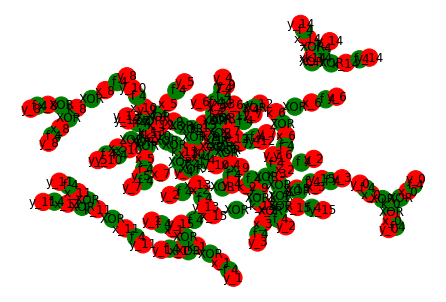

In [19]:
graph = build_graph_from_file(file_name,Nk=256,public=None,it=3)
graph.plot()

TODO: this graph generation can also be used to generate the labels if the secrets variables are also specified. This will be in another tutorial (which is not done yet).

## Step 2: Traces collection

In order to profile variables within the factor graph, one has to generate data. Stella is expecting to have the profiling traces in specific format.
* The traces are stored in the form [PREFIX_TRACES]\_[x].npy where x is an index. The traces are stored alone in a npy file for efficiency reasons. The traces are expected to be of int16 type (i.e. picoscope output).
* The corresponding labels to the traces are in [PREFIX_LABELS]\_[x].npz. This file contains a list of dictionaries. Each dictionary contains a key 'label' of the variable to profile. It also contains the 'val' key which is the list of values of the variable to profile. 

Next, we generate the traces according to the settings from [sasca_flow_settings.py](sasca_flow_settings.py). Of course, the traces can also be real traces taken from a scope.

In [4]:
from sasca_flow_settings import *
from sasca_flow import *

print("# Generate Traces")
gen_traces_sim(nfile_profile,ntraces,DIR_PROFILE_TRACES,tag)
gen_traces_attack_sim(nfile_attack,ntraces_attack,DIR_ATTACK_TRACES,tag)

print("# Generate Labels")
gen_labels(nfile_profile,DIR_PROFILE_TRACES,DIR_PROFILE_LABELS,tag)

example_labels = np.load(DIR_PROFILE_LABELS+tag+"_labels_0.npz",
                         allow_pickle=True)["labels"]

for label in example_labels[:4]: print("#",label)
    
print("#",PREFIX_PROFILE_LABELS)


# Generate Traces
(2000, 47)
(2000, 47)
(2000, 47)
(2000, 47)
(2000, 47)
(2000, 47)
(2000, 47)
(2000, 47)
(2000, 47)
(2000, 47)
# Generate Labels
# {'label': 'x_0', 'val': array([  0, 113,   2, ..., 175,  25, 100], dtype=uint8)}
# {'label': 'x_1', 'val': array([227,  88,  73, ..., 142,  65, 178], dtype=uint8)}
# {'label': 'x_2', 'val': array([ 98, 162,  60, ...,  59,  45, 152], dtype=uint8)}
# {'label': 'x_3', 'val': array([189,   9,  59, ...,  97,  50, 224], dtype=uint8)}
# /tmp/stella_ex/profile/labels/example_labels


## Step 3: Profiling variables

In order to profile variables, Stella works in three steps:
1. Compute SNR on the variables by taking as input the traces and the labels.
2. Extract the POIs based on the SNR computation.
3. Build the model for the variable based on traces at the POIs and labels.

We first parse the file to recover the flags to profile.

In [5]:
_,profile,_ = extract_flags(file_name)
profile = list(map(lambda l: l["label"],profile))
print("variables to profile :",profile)

variables to profile : ['y_0', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'y_10', 'y_11', 'y_12', 'y_13', 'y_14', 'y_15', 't_0_1', 't_1_2', 't_2_3', 't_3_4', 't_4_5', 't_5_6', 't_6_7', 't_7_8', 't_8_9', 't_9_10', 't_10_11', 't_11_12', 't_12_13', 't_13_14', 't_14_15']


Stella implements the function write_snr() that the specified traces and labels. It then computes the SNR incrementally by loading the files one by one. The arguments specifies:
* Where to load the traces, the labels and where to store the results
* The number of files available to perform the attack
* The labels to be profiled
* The batch_size, which is the number of SNR computed in a single pass. -1 means that SNR on all labels is done in a single pass.
* The number of classes to compute the SNR on (typically 256 for 8-bit variables).

In [6]:
print("# 1. Computing the SNR on the files")

write_snr(PREFIX_PROFILE_TRACES,
                PREFIX_PROFILE_LABELS,
                FILE_SNR,
                nfile_profile,
                profile,
                verbose=True,
                batch_size=-1,
                Nc=Nk)

# 1. Computing the SNR on the files
y_0 2.0112
y_1 2.0096
y_2 2.0062
y_3 2.0092
y_4 2.0105
y_5 1.9938
y_6 2.0027
y_7 2.0152
y_8 2.0106
y_9 2.0243
y_10 2.0125
y_11 2.0103
y_12 2.0129
y_13 2.0121
y_14 2.0193
y_15 2.0006
t_0_1 2.0032
t_1_2 2.0091
t_2_3 2.0041
t_3_4 2.0077
t_4_5 2.0095
t_5_6 2.0116
t_6_7 2.0177
t_7_8 2.0109
t_8_9 2.0159
t_9_10 1.9996
t_10_11 2.0033
t_11_12 2.0114
t_12_13 2.0147
t_13_14 2.0055
t_14_15 2.0104


In order to select the points of interest, the user is asked to provide a POI selection method that takes as input the snr and return the POIs. In the following example, it returns all 4 more leaking dimensions if the snr is larger the threshold for these variables. Else, it returns only the onces that are larger of the threshold.

The function write_poi will apply it to the SNR of all variables to profile and store the results.

In [7]:
def poi_selection(snr):
    ndim = 4
    return np.argsort(snr)[-ndim:] if len(np.where(snr>0.01)[0]) > ndim else np.where(snr>0.01)[0]

print("# 2. Getting POIs")
write_poi(FILE_SNR,FILE_POI,
            profile,
            poi_selection)

print("POIs :")
for x in np.load(FILE_POI,allow_pickle=True)["poi"][:4]: print(x)

# 2. Getting POIs
POIs :
{'poi': array([0]), 'label': 'y_0'}
{'poi': array([1]), 'label': 'y_1'}
{'poi': array([2]), 'label': 'y_2'}
{'poi': array([3]), 'label': 'y_3'}


A similar approach is taken to build the model. 

Below, we use a LDAClassifier from Stella to build the templates. It is a template applied to the output of a LDA dimensionality reduction. Stella works with any profiling methods which is can be changed by the user. It should only return an object that implements predict_proba(traces).
As an example, you can uncomment some lines and use QDA from sklearn.

This step is typically the most expensive if the profiling. Of course, it depends on the method used.

In [8]:
from stella.estimator.classifiers import LDAClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

print("# 3. Building templates")
def model_fit(t,l,label):
    #m = QDA()
    #m.fit(t,l)
    m = LDAClassifier(t,l,solver="eigen",dim_projection=1)
    return m

build_model(PREFIX_PROFILE_TRACES,
                PREFIX_PROFILE_LABELS,
                FILE_POI,
                FILE_MODEL,
                nfile_profile,
                profile,
                model_fit,batch_size=-1)
print("models :")
for x in np.load(FILE_MODEL,allow_pickle=True)["model"][:4]: print(x)

# 3. Building templates
models :
{'label': 'y_0', 'poi': array([0]), 'model': <stella.estimator.classifiers.LDAClassifier object at 0x7f882912e8d0>}
{'label': 'y_1', 'poi': array([1]), 'model': <stella.estimator.classifiers.LDAClassifier object at 0x7f882912e0b8>}
{'label': 'y_2', 'poi': array([2]), 'model': <stella.estimator.classifiers.LDAClassifier object at 0x7f882912e1d0>}
{'label': 'y_3', 'poi': array([3]), 'model': <stella.estimator.classifiers.LDAClassifier object at 0x7f882912e518>}


## Step 3: Init the factor graph

Next, we will init the memory used to run BP. This goes in two steps. First, Stella parses the file and unrolls the loop. At the same time, it builds a graph with the relationships between the variables. 
To perform this first step, Stella will build the graph by taking as input a memory array for the public inputs. To process fresh data, the user have to modify this array accordingly in order to avoid the time consuming array initialization phase. The function build_graph_from_file() returns a factor graph object. Then, the lookup tables are set

In [9]:
# Settings for the attack and generate the labels for public, secret and profile variables
print("\n# Attack Part")
ntraces_attack = 100
LOOP_IT = ntraces_attack; repeat = 1;

public,profile,secret = extract_flags(file_name)


# Attack Part


In [10]:
for v in public: v["input"] = np.zeros((LOOP_IT,repeat),dtype=np.uint32) if v["loop"] else np.zeros((1,repeat),dtype=np.uint32)
for x in public[:1]: print(list(x), "with input shape", x["input"].shape)

loopup = sbox.astype(np.uint32).reshape((1,Nk))
print("# 1. Build Graph",flush=True)
graph = build_graph_from_file(file_name,Nk=Nk,it=LOOP_IT,public=public,lookup=loopup)


['label', 'loop', 'input'] with input shape (100, 1)
# 1. Build Graph


Loop generation: 100%|██████████| 100/100 [00:00<00:00, 347.92it/s]


Once the relations between the variables are described, the graph memory has to be initialized. This is performed by the function initialize_graph_from_file(). It returns two values:
1. A list of dictionaries of the profiled variables. The user then has to modify the data contained in the field 'distri' to set the intial distribution of the variable. This will typically be done by using the models done in the previous profiling steps
2. A list of dictionaries for the secrets. It also contains a field 'distri' which contains the estimated distribution of that secret variable.

In [11]:
print("# 2. Init Attack Graph",flush=True)
secret,profile = initialize_graph_from_file(graph,file_name,verbose=False,Nk=Nk,LOOP_IT=LOOP_IT)

# 2. Init Attack Graph


Init FNodes: 100%|██████████| 4700/4700 [00:00<00:00, 18275.95it/s]


## Step 4: Running Attacks 

First, the user loads the models generated during the profiling phase. 

In [12]:
print("# 3. Load models")
model = np.load(FILE_MODEL,allow_pickle=True)["model"]

public_l = np.array([x["label"] for x in public])
model_l = np.array([x["label"] for x in model])

for x in model[:4]: print(x)

# 3. Load models
{'label': 'y_0', 'poi': array([0]), 'model': <stella.estimator.classifiers.LDAClassifier object at 0x7f87ff820e10>}
{'label': 'y_1', 'poi': array([1]), 'model': <stella.estimator.classifiers.LDAClassifier object at 0x7f8831295860>}
{'label': 'y_2', 'poi': array([2]), 'model': <stella.estimator.classifiers.LDAClassifier object at 0x7f8831295da0>}
{'label': 'y_3', 'poi': array([3]), 'model': <stella.estimator.classifiers.LDAClassifier object at 0x7f8831296320>}


Then, we repeat attacks by doing the following steps:
1. Load the traces and the corresponding plaintexts (and key to check if the attack worked).
2. For each of the profiled variable, updates its initial distribution by using the model.
3. Set the public inputs (the plaintext if the its a known plaintext attack) by modifying the corresponding memory
4. Perform some iterations of Belief Pro

In [13]:
print("# 4. Performing Attacks")

for f in range(nfile_attack):
    t = np.load(DIR_ATTACK_TRACES+tag+"_traces_%d.npy"%(f))
    dic = np.load(DIR_ATTACK_TRACES+tag+"_meta_%d.npz"%(f),allow_pickle=True)
    pt = dic["p"]
    k = dic["k"]
    
    # compute proba on all the profiled variables
    for p in profile:
        m = model[np.where(model_l == p["label"])[0][0]]
        p["distri"][:,:] = m["model"].predict_proba(t[:ntraces_attack,m["poi"]])


    # set the public inputs
    for p in public:
        code = p["label"].split('_')[0]
        i = int(p["label"].split('_')[1])
        if code == "p":
            p["input"][:,0] = pt[:ntraces_attack,i]
        else:
            raise Exception("code not found")
        
    graph.run_bp(it=5)

    print("\n# Attack #%d"%(f))
    print("# correct key   :",' '.join([" %02x"%(x) for x in k[:len(secret)]]))
    print("# key found     :",' '.join([" %02x"%(np.argmax(np.sum(np.log10(s["distri"]),axis=0))) for s in secret]))
    print("# key byte rank :",' '.join(["%03d"%(256 - np.where(np.argsort(np.cumsum(np.log10(s["distri"]),axis=0)[-1,:])==x)[0][0]) for s,x in zip(secret,k)]))


# 4. Performing Attacks

# Attack #0
# correct key   :  45  8e  05  29  19  eb  78  56  54  7a  90  76  a0  1b  9c  f5
# key found     :  45  8e  05  29  19  eb  78  56  54  7a  90  76  a0  1b  9c  f5
# key byte rank : 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001

# Attack #1
# correct key   :  03  d4  8d  62  12  ba  ca  1d  0a  09  41  b6  d1  a3  49  f8
# key found     :  03  d4  8d  62  12  ba  ca  1d  0a  09  41  b6  d1  a3  49  f8
# key byte rank : 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001

# Attack #2
# correct key   :  1e  41  1d  fc  f3  0c  dd  c0  6f  33  38  e7  cf  17  72  4d
# key found     :  1e  41  1d  fc  f3  0c  dd  c0  6f  33  38  e7  cf  17  72  4d
# key byte rank : 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001

# Attack #3
# correct key   :  84  fd  43  48  11  d0  d5  66  d9  21  d2  da  f2  75  0a  ad
# key found     :  84  fd  43  48  11  d0  d5  66  d9  21  d2  da  f2  75  0a  ad
# key byte rank : 001 